In [1]:
%config IPCompleter.greedy=True  # Podpowiedzi składni
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random
import itertools
import math
import copy
import time
from sortedcontainers import SortedList

# Własna funkcja zaokrąglająca
def round2(number):
    if (number - math.trunc(number) >= 0.5):
        return math.trunc(number) + 1
    else:
        return math.trunc(number)

In [2]:
file = open('kroA200.tsp.txt')
# file = open('kroB200.tsp.txt')

In [3]:
# Pomiń zbędne linie

next_line = file.readline()[0:-1]
while next_line[0] != "1":
    next_line = file.readline()[0:-1]
print(next_line)

1 1357 1905


In [4]:
# Wczytaj wszystkie punkty do tablicy

points_tab = []
while next_line!= "EOF":
    points_tab.append(next_line.split(" "))
    next_line = file.readline()[0:-1]

In [5]:
for x in range(len(points_tab)):
    for y in range(len(points_tab[0])):
        points_tab[x][y] = int(points_tab[x][y])
    points_tab[x][0] = points_tab[x][0] - 1  # zmniejsz identyfikatory punktów o 1
print(len(points_tab))
print(len(points_tab[0]))


#print(points_tab)

200
3


In [6]:
# Utwórz tablicę odległości między punktami

length_tab = list(np.zeros((len(points_tab),len(points_tab)), dtype=int))
for x in range(len(length_tab)):
    for y in range(len(length_tab[0])):
        length_tab[x][y] = round2(math.sqrt((points_tab[x][1] - points_tab[y][1])**2 + (points_tab[x][2] - points_tab[y][2])**2))  # długość między punktem "x" i "y" w tablicy base_tab

        
#print(length_tab)

In [7]:
# Funkcja zwracająca długość ścieżki

def distance(path):
    dist = 0
    for x in range(len(path) - 1):
        dist+=length_tab[path[x]][path[x+1]]
    dist+=length_tab[path[len(path)-1]][path[0]]
    return dist

In [8]:
# funkcja zwracająca losową ścieżkę

def get_random_path(data_size):
    path = np.arange(data_size)
    np.random.shuffle(path)
    inside = list(path[:int(data_size/2)])
    outside = list(path[int(data_size/2):])
    return inside, outside

In [9]:
# Funkcja rysująca punkty na płaszczyźnie - zależnie od pochodzenia odpowiednio w różnych kolorach, połączone lub nie

def print_graph(path, out):
    points_inside = []
    points_outside = []

    plt.figure()
    for i in path:
        points_inside.append(copy.deepcopy(points_tab[i][1:]))
    for i in out:
        points_outside.append(copy.deepcopy(points_tab[i][1:]))

    points_inside_0 = []
    for x in points_inside:
        points_inside_0.append(copy.deepcopy(x[0]))
    points_inside_0.append(copy.deepcopy(points_inside[0][0]))
    
    points_inside_1 = []
    for x in points_inside:
        points_inside_1.append(copy.deepcopy(x[1]))
    points_inside_1.append(copy.deepcopy(points_inside[0][1]))

    points_outside_0 = []
    for x in points_outside:
        points_outside_0.append(copy.deepcopy(x[0]))
    points_outside_1 = []
    for x in points_outside:
        points_outside_1.append(copy.deepcopy(x[1]))

    plt.plot(points_inside_0,points_inside_1, '-o')
    plt.plot(points_outside_0,points_outside_1, 'o')
    plt.show()

    
#print_graph(path, out)

In [10]:
# Funkcje pomocnicze

def p_dist(a, b):  
    return length_tab[a][b]

def out_of(a, size = 100):  
    if a < 0:
        a = size + a
    if a >= size:
        a = a - size
    return a

In [11]:
def give_best_edges(path):
    best_imp1 = 0
    best_edges = []

    for x in range(len(path))[:]:  # Dla każdej krawędzi
        for y in range(len(path))[:]:  # Dla każdej innej krawędzi
            if x!=y:

                new_imp = p_dist(path[x], path[out_of(x+1)]) + p_dist(path[y], path[out_of(y+1)]) - p_dist(path[x], path[y]) - p_dist(path[out_of(x+1)], path[out_of(y+1)])
                if new_imp > best_imp1:  # Jeśli jest to lepsze rozwiązanie, zapamiętaj je
                    best_imp1 = new_imp
                    best_edges = [x, y]
    
    return best_imp1, best_edges


def give_best_vertices(path, out):
    best_imp2 = 0
    best_vertices = []
    
    for x in range(len(path))[:]:  # Dla każdego wierzchołka ze ścieżki
            for y in range(len(out))[:]:  # Dla każdego wierzchołka spoza ścieżki

                new_imp = p_dist(path[out_of(x-1)], path[x]) + p_dist(path[x], path[out_of(x+1)]) - p_dist(path[out_of(x-1)], out[y]) - p_dist(out[y], path[out_of(x+1)])
                if new_imp > best_imp2:  # Jeśli jest to lepsze rozwiązanie, zapisz zmiany
                    best_imp2 = new_imp
                    best_vertices = [x, y]
                    
    return best_imp2, best_vertices


In [12]:
def change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices):
    if best_imp1 >= best_imp2:
        #podmień krawędzie
        x = best_edges[0]
        y = best_edges[1]

        for z in range(int(abs(y - x)/2)):  # Zamiana krawędzi, czyli obrócenie kolejności (krawędź1; krawędź2>
            if x < y:
                path[x + 1 + z], path[y - z] = path[y - z], path[x + 1 + z]
            else:
                path[y + 1 + z], path[x - z] = path[x - z], path[y + 1 + z]
    else:
        #podmień punkty
        x = path[best_vertices[0]]
        y = out[best_vertices[1]]

        path.insert(path.index(x), y)
        path.remove(x)

        out.append(x)
        out.remove(y)

In [13]:
# Liczba powtórzeń testowych

repeat = 1

# MSLS



18231


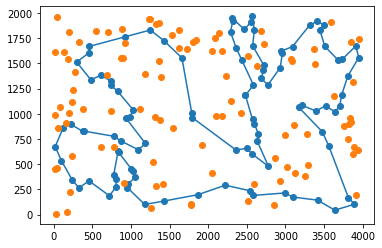

Min_path: 18231
Average_path: 18231.0
Max_path: 18231

Min_time: 8.713055099999998
Average_time: 8.713055099999998
Max_time: 8.713055099999998


In [18]:
'''
min, max i średnia długość ścieżki i czas
najlepsze rozwiązanie jako path i out
'''
min_path = 1000000
average_path = 0
max_path = 0

min_time = time.perf_counter() + 100
average_time = 0
max_time = 0

best_path = [0]
best_out = [0]



for omega in range(repeat):  # powtórz testy n razy
    path, out = get_random_path(len(points_tab))
    path_time = time.perf_counter()

    while(True):
        best_imp1, best_edges = give_best_edges(path)
        best_imp2, best_vertices = give_best_vertices(path, out)

        # Jeśli znaleziono jakąś poprawę: zapisz rezultat
        if best_imp1 > 0 or best_imp2 > 0:  
            change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices)    
        
        # Warunek stopu
        else:
            break

    
    path_time = time.perf_counter() - path_time
    
    if distance(path) < min_path:
        min_path = distance(path)
        best_path = path
        best_out = out
    if distance(path) > max_path:
        max_path = distance(path)
    average_path += distance(path)
    
    if path_time < min_time:
        min_time = path_time
    if path_time > max_time:
        max_time = path_time
    average_time += path_time
    
    
    print("\n")
    print(distance(path))
    print_graph(path, out)
    
    
print("Min_path: "+str(min_path))
print("Average_path: "+str(average_path/repeat))
print("Max_path: "+str(max_path))
print()
print("Min_time: "+str(min_time))
print("Average_time: "+str(average_time/repeat))
print("Max_time: "+str(max_time))

In [15]:
MSLS_AVG = average_time / repeat
print(MSLS_AVG)

8.1690746


# ILS1



16848


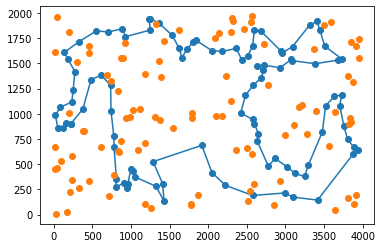

Min_path: 16848
Average_path: 16848.0
Max_path: 16848

Min_time: 8.224512599999999
Average_time: 8.224512599999999
Max_time: 8.224512599999999


In [16]:
from random import randrange
import time

'''
min, max i średnia długość ścieżki i czas
najlepsze rozwiązanie jako path i out
'''
min_path = 1000000
average_path = 0
max_path = 0

min_time = time.perf_counter() + 100
average_time = 0
max_time = 0

best_path = [0]
best_out = [0]



for omega in range(repeat):  # powtórz testy n razy
    path, out = get_random_path(len(points_tab))
    path_time = time.perf_counter()

    while(True):
        best_imp1, best_edges = give_best_edges(path)
        best_imp2, best_vertices = give_best_vertices(path, out)

        # Jeśli znaleziono jakąś poprawę, zapisz rezultat
        if best_imp1 > 0 or best_imp2 > 0:  
            change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices)         
        

        # Zamiana wierzchołkow
        v_swap_path = copy.deepcopy(path)
        v_swap_out = copy.deepcopy(out)
        
        for vertice in range(2):
            x = v_swap_path[randrange(100)]
            y = v_swap_out[randrange(100)]

            v_swap_path.insert(v_swap_path.index(x), y)
            v_swap_path.remove(x)

            v_swap_out.append(x)
            v_swap_out.remove(y)
         
        # Zamiana krawędzi
        for edge in range(2):
            x = randrange(100)
            y = randrange(100)

            for z in range(int(abs(y - x)/2)):  # Zamiana krawędzi, czyli obrócenie kolejności (krawędź1; krawędź2>
                if x < y:
                    v_swap_path[x + 1 + z], v_swap_path[y - z] = v_swap_path[y - z], v_swap_path[x + 1 + z]
                else:
                    v_swap_path[y + 1 + z], v_swap_path[x - z] = v_swap_path[x - z], v_swap_path[y + 1 + z]

        if distance(v_swap_path) < distance(path):
            path = copy.deepcopy(v_swap_path)
            out = copy.deepcopy(v_swap_out)
            

        
        # Warunek stopu
        if time.perf_counter() - path_time > MSLS_AVG:
            break

    
    path_time = time.perf_counter() - path_time
    
    if distance(path) < min_path:
        min_path = distance(path)
        best_path = path
        best_out = out
    if distance(path) > max_path:
        max_path = distance(path)
    average_path += distance(path)
    
    if path_time < min_time:
        min_time = path_time
    if path_time > max_time:
        max_time = path_time
    average_time += path_time
    
    print("\n")
    print(distance(path))
    print_graph(path, out)
    
    
print("Min_path: "+str(min_path))
print("Average_path: "+str(average_path/repeat))
print("Max_path: "+str(max_path))
print()
print("Min_time: "+str(min_time))
print("Average_time: "+str(average_time/repeat))
print("Max_time: "+str(max_time))

# ILS2



13873


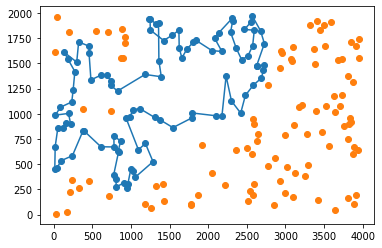

Min_path: 13873
Average_path: 13873.0
Max_path: 13873

Min_time: 8.581240600000001
Average_time: 8.581240600000001
Max_time: 8.581240600000001


In [17]:
'''
min, max i średnia długość ścieżki i czas
najlepsze rozwiązanie jako path i out
'''
min_path = 1000000
average_path = 0
max_path = 0

min_time = time.perf_counter() + 100
average_time = 0
max_time = 0

best_path = [0]
best_out = [0]



for omega in range(repeat):  # powtórz testy n razy
    path, out = get_random_path(len(points_tab))
    path_time = time.perf_counter()

    while(True):
        
        # Znalezienie najlepszych wymian
        best_imp1, best_edges = give_best_edges(path)
        best_imp2, best_vertices = give_best_vertices(path, out)

        # Jeśli znaleziono jakąś poprawę: zapisz rezultat
        if best_imp1 > 0 or best_imp2 > 0:  
            change_your_path(path, out, best_imp1, best_imp2, best_edges, best_vertices)
            
            

        new_path = copy.deepcopy(path)
        new_out = copy.deepcopy(out)
        
        
        # Wyrzucenie 20 wierzchołków
        r = random.randint(0, len(new_path) - 1)
        for x in range(20):
            new_out.append(new_path[out_of(x + r)])
            new_path[out_of(x + r)] = -1
        for x in range(20):
            new_path.remove(-1)
        
        
        
        # Dopisanie 20 nowych wierzchołków
        while len(new_path) < len(path):  # tak długo jak brakuje wierzchołków szukaj kolejnego
            min_cost = 100000
            previous_point_index = 0
            best_point = 0
            for new_point in new_out:  # dla każdego punktu
                for x in range(len(new_path)):  # dla każdej krawędzi
                    point1 = new_path[x]
                    point2 = new_path[0]
                    if x != len(new_path) - 1:
                        point2 = new_path[x + 1]

                    cost = length_tab[point1][new_point] + length_tab[point2][new_point] - length_tab[point1][point2]
                    if cost < min_cost:
                        min_cost = cost
                        previous_point_index = x
                        best_point = new_point

            new_path.insert(previous_point_index + 1, best_point)  # wstaw nowy punkt za miejscem previous point
            new_out.remove(best_point)

        if distance(new_path) < distance(path):
            path = copy.deepcopy(new_path)
            out = copy.deepcopy(new_out)

            
        # Warunek stopu
        if time.perf_counter() - path_time > MSLS_AVG:
            break
        
        
        
    path_time = time.perf_counter() - path_time
    
    if distance(path) < min_path:
        min_path = distance(path)
        best_path = path
        best_out = out
    if distance(path) > max_path:
        max_path = distance(path)
    average_path += distance(path)
    
    if path_time < min_time:
        min_time = path_time
    if path_time > max_time:
        max_time = path_time
    average_time += path_time
    
    
    print("\n")
    print(distance(path))
    print_graph(path, out)
    
    
print("Min_path: "+str(min_path))
print("Average_path: "+str(average_path/repeat))
print("Max_path: "+str(max_path))
print()
print("Min_time: "+str(min_time))
print("Average_time: "+str(average_time/repeat))
print("Max_time: "+str(max_time))